<a href="https://colab.research.google.com/github/Olatokumbo/posture-classification/blob/main/Posture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import random
from scipy.ndimage import rotate, gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


<ipython-input-1-87399275ed9c>:8: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


Import 5 Base Postures from CSV

In [2]:
def scale_posture(posture, new_size):
    """
    Scales the given posture to the new sensor size using interpolation.

    Parameters:
    - posture: The original posture array (2D).
    - new_size: A tuple (new_rows, new_cols) indicating the desired sensor size.

    Returns:
    - The scaled posture array.
    """
    original_size = posture.shape
    row_scale = new_size[0] / original_size[0]
    col_scale = new_size[1] / original_size[1]
    return zoom(posture, (row_scale, col_scale))

def read_csv_to_array(file_path):
    return pd.read_csv(file_path, header=None).values

directory = "/content/dataset"

In [46]:

# postures = {
#     "upright": {"backrest": read_csv_to_array(f"{directory}/up-backrest.csv"), "seat": read_csv_to_array(f"{directory}/up-sit.csv")},
#     "slouching": {"backrest": read_csv_to_array(f"{directory}/sl-backrest.csv"), "seat": read_csv_to_array(f"{directory}/sl-sit.csv")},
#     "left-leaning": {"backrest": read_csv_to_array(f"{directory}/ll-backrest.csv"), "seat": read_csv_to_array(f"{directory}/ll-sit.csv")},
#     "right-leaning": {"backrest": read_csv_to_array(f"{directory}/rl-backrest.csv"), "seat": read_csv_to_array(f"{directory}/rl-sit.csv")},
#     "leaning-back": {"backrest": read_csv_to_array(f"{directory}/lb-backrest.csv"), "seat": read_csv_to_array(f"{directory}/lb-sit.csv")},
# }

In [5]:
def generate_scaled_postures(directory, new_size):
    postures = {
        "upright": {"backrest": read_csv_to_array(f"{directory}/up-backrest.csv"), "seat": read_csv_to_array(f"{directory}/up-sit.csv")},
        "slouching": {"backrest": read_csv_to_array(f"{directory}/sl-backrest.csv"), "seat": read_csv_to_array(f"{directory}/sl-sit.csv")},
        "left-leaning": {"backrest": read_csv_to_array(f"{directory}/ll-backrest.csv"), "seat": read_csv_to_array(f"{directory}/ll-sit.csv")},
        "right-leaning": {"backrest": read_csv_to_array(f"{directory}/rl-backrest.csv"), "seat": read_csv_to_array(f"{directory}/rl-sit.csv")},
        "leaning-back": {"backrest": read_csv_to_array(f"{directory}/lb-backrest.csv"), "seat": read_csv_to_array(f"{directory}/lb-sit.csv")},
    }

    scaled_postures = {}
    for posture_name, posture_parts in postures.items():
        backrest_scaled = scale_posture(posture_parts["backrest"], new_size)
        seat_scaled = scale_posture(posture_parts["seat"], new_size)
        scaled_postures[posture_name] = {"backrest": backrest_scaled, "seat": seat_scaled}

    return scaled_postures

# Example usage
new_size = (10, 10)  # New sensor size
scaled_postures = generate_scaled_postures(directory, new_size)


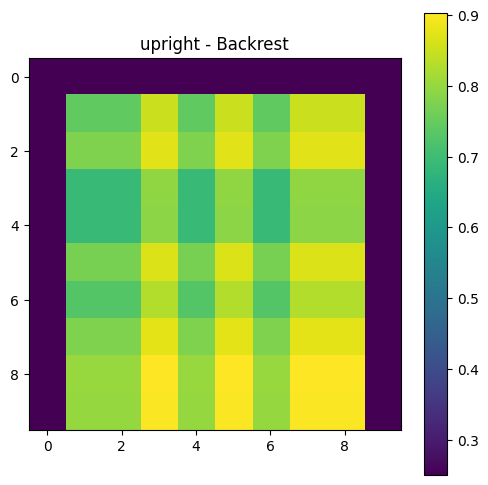

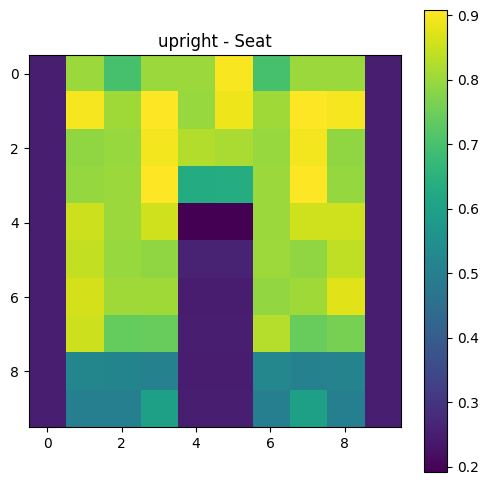

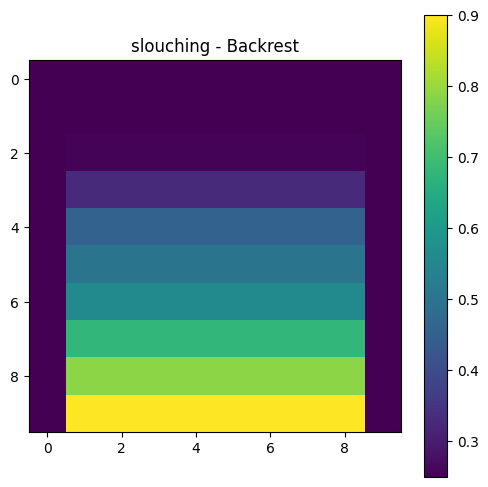

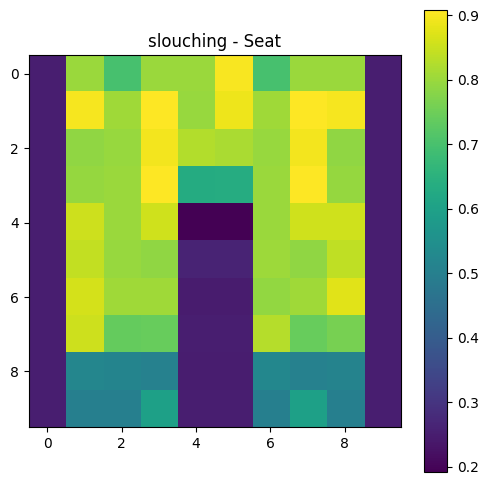

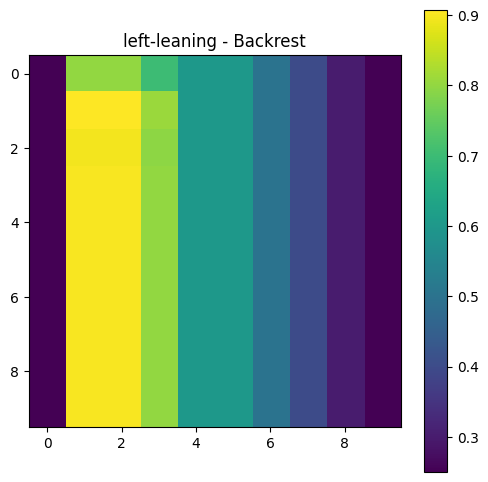

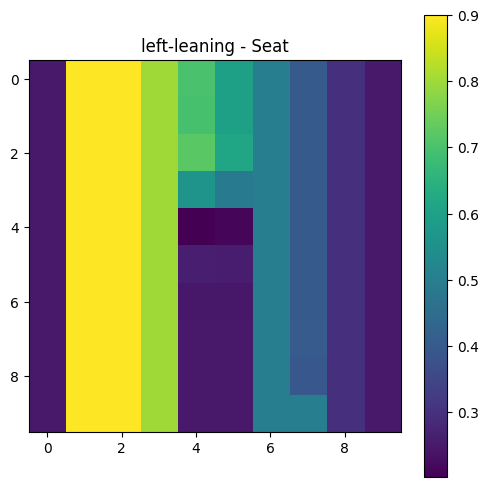

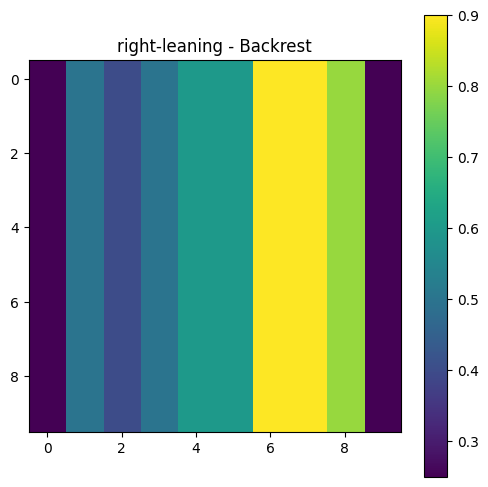

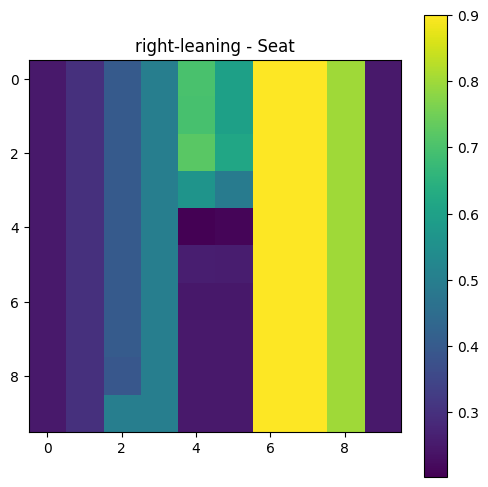

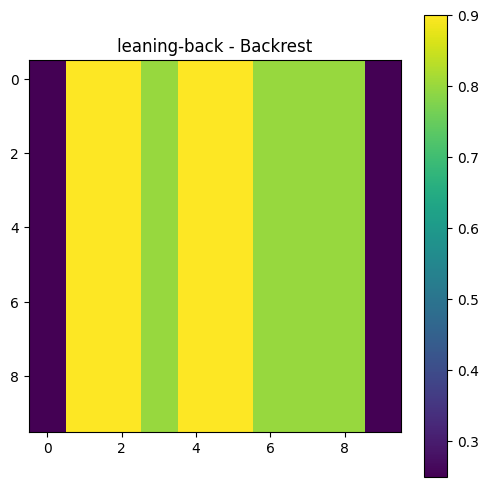

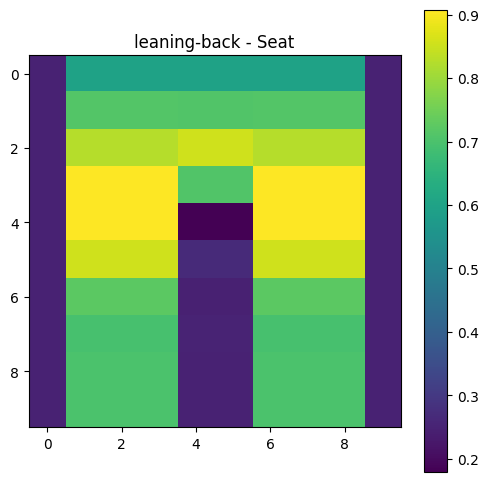

In [6]:
def plot_heatmap(data, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot the heatmaps for each scaled posture
for posture_name, posture_parts in scaled_postures.items():
    plot_heatmap(posture_parts["backrest"], f"{posture_name} - Backrest")
    plot_heatmap(posture_parts["seat"], f"{posture_name} - Seat")

Data Augmentation Script

In [7]:
# Add Noise to the Data
def add_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# Scale the Data
def scale_data(data, scale_factor=0.1):
    scale = 1 + np.random.uniform(-scale_factor, scale_factor)
    return data * scale

# Shift the Data
def shift_data(data, shift_max=1):
    shift_x = np.random.randint(-shift_max, shift_max)
    shift_y = np.random.randint(-shift_max, shift_max)
    shifted_data = np.roll(data, shift_x, axis=0)
    shifted_data = np.roll(shifted_data, shift_y, axis=1)
    return shifted_data

# Reflect the Data
def reflect_data(data, axis=0):
    return np.flip(data, axis=axis)

# Rotate the Data
def rotate_data(data, angle):
    return rotate(data, angle, reshape=False)

# Apply Gaussian Blur
def apply_gaussian_blur(data, sigma=1):
    return gaussian_filter(data, sigma=sigma)

# Random Erasing
def random_erasing(data, erase_prob=0.5, erase_size=0.1):
    if random.random() < erase_prob:
        h, w = data.shape
        erase_h = int(h * erase_size)
        erase_w = int(w * erase_size)
        top = np.random.randint(0, h - erase_h)
        left = np.random.randint(0, w - erase_w)
        data[top:top + erase_h, left:left + erase_w] = 0
    return data

# Elastic Deformations
def elastic_transform(data, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = data.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))
    return map_coordinates(data, indices, order=1, mode='reflect').reshape(shape)

# Adjust Brightness
def adjust_brightness(data, factor=1.5):
    return np.clip(data * factor, 0, 255)

# Adjust Contrast
def adjust_contrast(data, factor=1.5):
    mean = np.mean(data)
    return np.clip((data - mean) * factor + mean, 0, 255)

# Clip Data
def clip_data(data, min_value=0, max_value=255):
    return np.clip(data, min_value, max_value)

# Complex Augmentation
def complex_augment_data(data, sample_size=10):
    augmented_data = []
    for _ in range(sample_size):
        aug_data = data.copy()
        if random.choice([True, False]):
            aug_data = add_noise(aug_data)
        if random.choice([True, False]):
            aug_data = scale_data(aug_data)
        if random.choice([True, False]):
            aug_data = shift_data(aug_data)
        if random.choice([True, False]):
            aug_data = rotate_data(aug_data, angle=np.random.uniform(-10, 10))
        # if random.choice([True, False]):
        #     aug_data = reflect_data(aug_data, axis=random.choice([0, 1]))
        if random.choice([True, False]):
            aug_data = apply_gaussian_blur(aug_data)
        if random.choice([True, False]):
            aug_data = random_erasing(aug_data)
        if random.choice([True, False]):
            aug_data = elastic_transform(aug_data, alpha=36, sigma=6)
        if random.choice([True, False]):
            aug_data = adjust_brightness(aug_data, factor=np.random.uniform(0.5, 1.5))
        if random.choice([True, False]):
            aug_data = adjust_contrast(aug_data, factor=np.random.uniform(0.5, 1.5))
        if random.choice([True, False]):
            aug_data = clip_data(aug_data, min_value=0, max_value=255)
        augmented_data.append(aug_data)
    return augmented_data


# Function to augment data for each posture
def generate_augmented_dataset(postures, sample_size_per_posture=10):
    augmented_dataset = []
    for posture_name, sensor_data in postures.items():
        augmented_backrest = complex_augment_data(sensor_data["backrest"], sample_size=sample_size_per_posture)
        augmented_seat = complex_augment_data(sensor_data["seat"], sample_size=sample_size_per_posture)
        for backrest, seat in zip(augmented_backrest, augmented_seat):
            augmented_dataset.append({"posture": posture_name, "backrest": backrest, "seat": seat})
    return augmented_dataset


Data Generation with 100 samples per Posture

In [8]:
augmented_dataset = generate_augmented_dataset(scaled_postures, sample_size_per_posture=1000)

def flatten_matrix(matrix):
    return np.array(matrix).flatten()

# Prepare the data for training
features = []
labels = []

for data_point in augmented_dataset:
    flat_backrest = flatten_matrix(data_point['backrest'])
    flat_seat = flatten_matrix(data_point['seat'])
    features.append(np.concatenate((flat_backrest, flat_seat)))
    labels.append(data_point['posture'])

X = np.array(features)
y = np.array(labels)

# Shuffle the data
# X, y = shuffle(X, y, random_state=42)

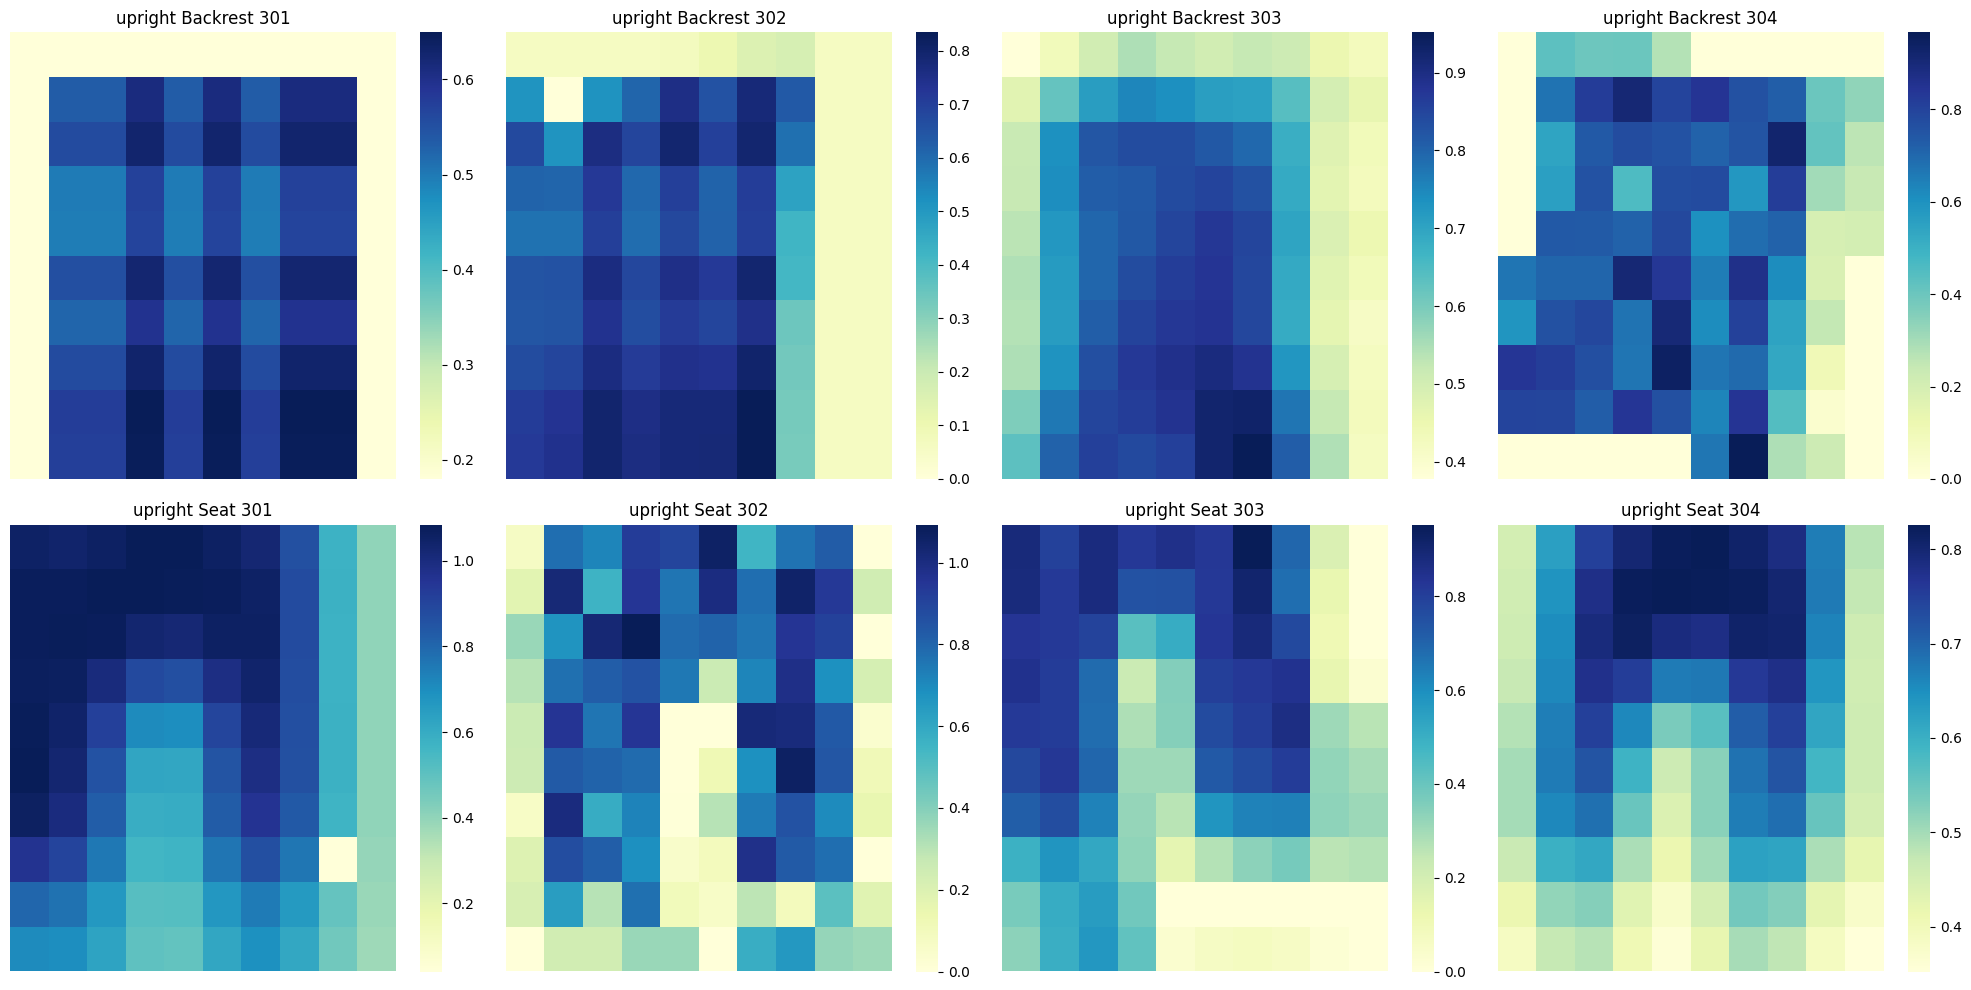

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization Function
def plot_heatmap(ax, data, title):
    sns.heatmap(data, cmap="YlGnBu", cbar=True, ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Visualize 5 samples after the nth augmented data sample
start_index = 300
num_samples_to_display = 4

fig, axes = plt.subplots(2, num_samples_to_display, figsize=(num_samples_to_display * 5, 10))

for i, entry in enumerate(augmented_dataset[start_index:start_index + num_samples_to_display]):
    plot_heatmap(axes[0, i], entry["backrest"], f"{entry['posture']} Backrest {start_index + i + 1}")
    plot_heatmap(axes[1, i], entry["seat"], f"{entry['posture']} Seat {start_index + i + 1}")

plt.tight_layout()
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Training and Testing

Training Random Forest...
Random Forest Accuracy: 97.00%


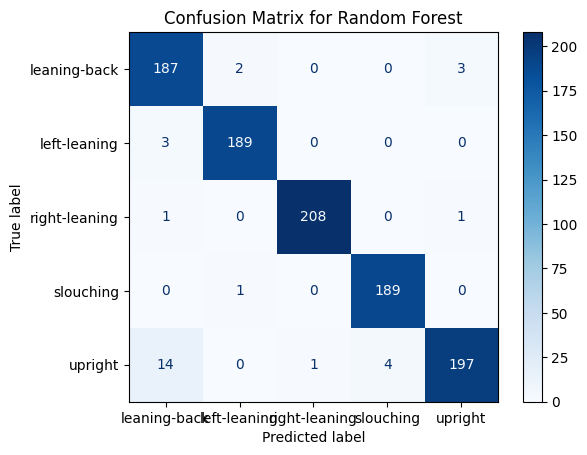

Training DecisionTreeClassifier...
DecisionTreeClassifier Accuracy: 89.70%


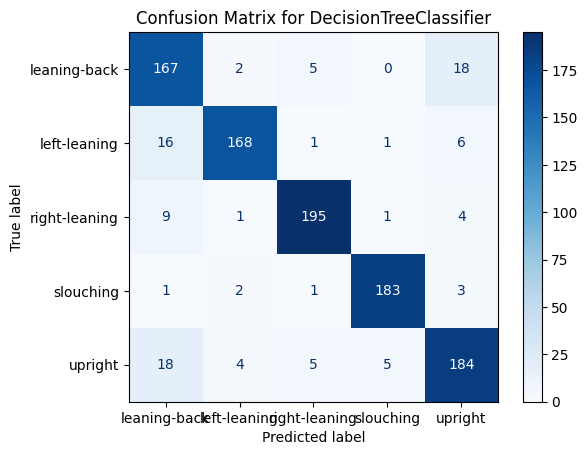

Training SVM...
SVM Accuracy: 97.60%


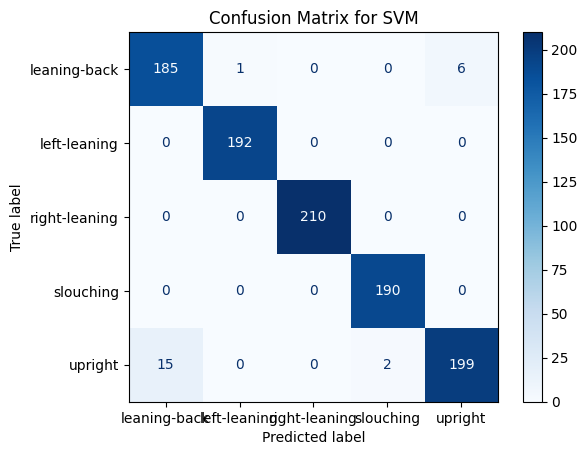

Training KNN...
KNN Accuracy: 91.70%


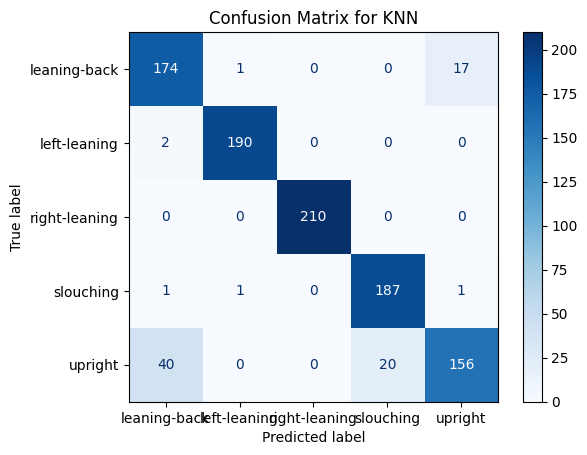

Training Gradient Boosting...
Gradient Boosting Accuracy: 97.80%


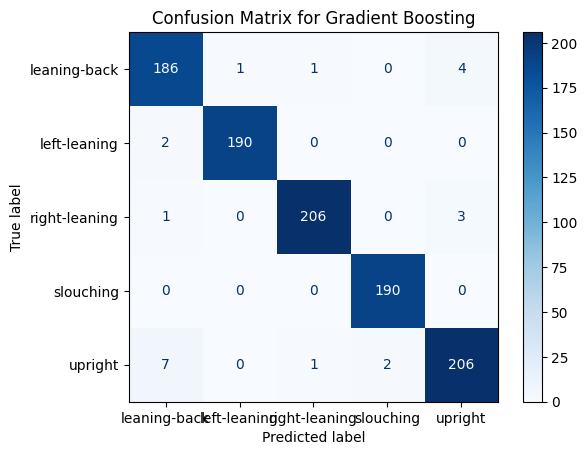

Training Neural Network...
Neural Network Accuracy: 98.50%


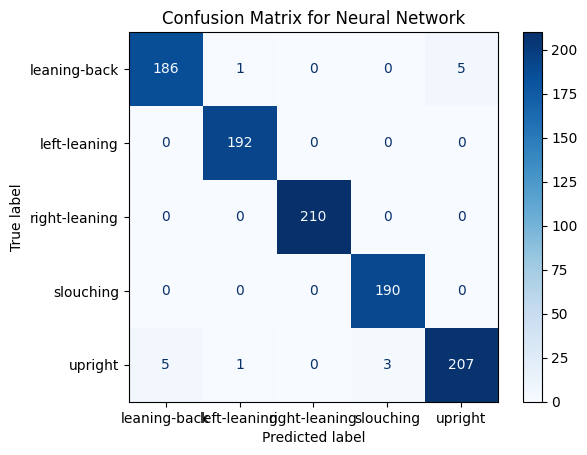

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Random Forest": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000),
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy * 100:.2f}%')

    # Compute confusion matrix
    unique_labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(unique_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [21]:
from joblib import dump, load
# Specify the model to save
model_to_save = "Neural Network"  # Specify the model name from the dictionary

# Save the specified model
if model_to_save in models:
    model_filename = f'{model_to_save.lower().replace(" ", "_")}.joblib'
    dump(models[model_to_save], model_filename)
    print(f"Model {model_to_save} saved as {model_filename}")
else:
    print(f"Model {model_to_save} not found in the dictionary")

Model Neural Network saved as neural_network.joblib
